In [95]:
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import numpy as np 
from keywords import renovations, aspects

%matplotlib inline

In [96]:
file="/home/yiyi/Documents/masterarbeit/CPD/data/sentiment_analysis/results/0#f116f785-8626-48f3-a390-c0c4a03b5bd6"

In [98]:
def get_df(file):
    df = pd.read_csv(file)

    df['date'] = df['date'].astype('datetime64')
    df = df[df['date']>= np.datetime64("2015-01-01")]
    df['sentiment'] = df['sentiment'].swifter.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

    df['lemma'] = df['lemma'].astype(str)
    df['sentence'] = df['sentence'].astype(str)
    df.drop_duplicates(subset=['sentence'], keep='first', inplace=True)

    df = df.sort_values('date')
    df['renovation'] = df.swifter.apply(lambda x: sum([y in x.lemma.lower().split() for y in renovations]) > 0, axis=1)
    df['other'] = df.swifter.apply(lambda x: sum([y in x.lemma.lower().split() for y in aspects]) > 0, axis=1)
    print(df['renovation'].to_list()[:10])
    print(df['other'].to_list()[:10])
    
#     groups = df.groupby('date')
    
#     cpd_df = groups.agg({"sentiment":"mean"})
    
#     print('length of cpd_df', len(cpd_df))
    return df

In [99]:
df = get_df(file)


[False, False, False, False, False, False, False, False, False, False]
[True, True, True, False, True, True, True, True, True, True]


In [100]:
df.to_csv('test.csv')

In [42]:
cpd_df = get_cpd_df(file)

length of cpd_df 1553


In [43]:
cpd_df.sentiment

date
2015-01-01   -0.005365
2015-01-02   -0.121293
2015-01-03    0.112017
2015-01-04   -0.231736
2015-01-05   -0.023132
                ...   
2020-03-04    0.109948
2020-03-05   -0.314568
2020-03-08    0.066141
2020-03-09    0.213687
2020-03-12    0.047531
Name: sentiment, Length: 1553, dtype: float64

In [30]:
cpd_df.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-08',
               '2020-03-09', '2020-03-12'],
              dtype='datetime64[ns]', name='date', length=1553, freq=None)

In [101]:
cpd_df['SMA_10']= cpd_df.sentiment.rolling(window=10).mean()

In [102]:
cpd_df['SMA_20']=cpd_df.sentiment.rolling(window=20).mean()

In [33]:
cpd_df['SMA_100']=cpd_df.sentiment.rolling(window=100).mean()

In [34]:
cpd_df.dtypes

sentiment    float64
SMA_10       float64
SMA_20       float64
SMA_100      float64
dtype: object

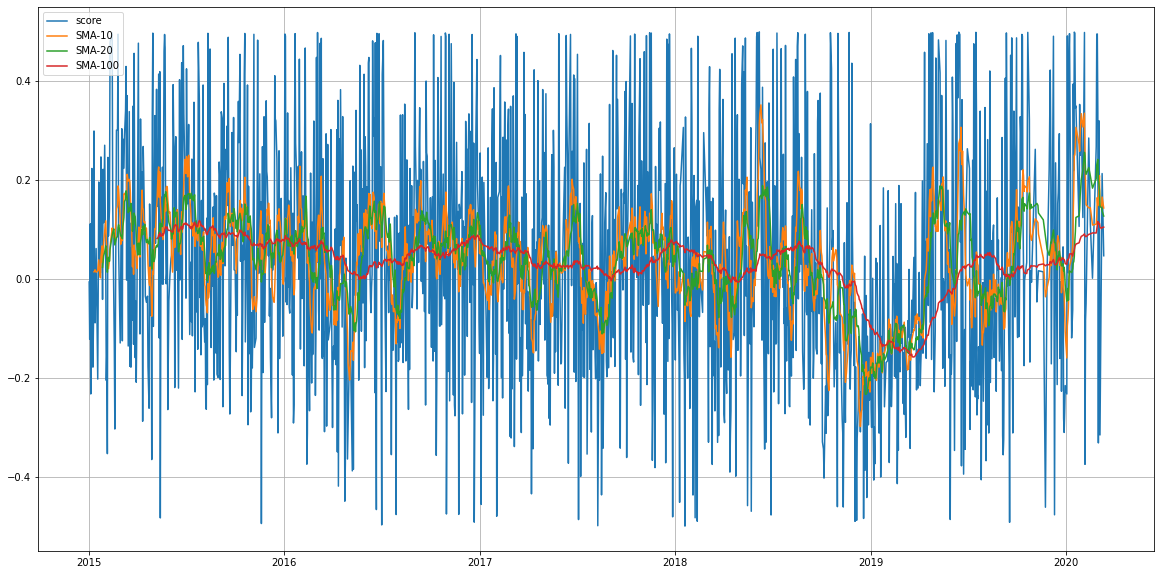

In [36]:
plt.figure(figsize=[20,10])
plt.grid(True)
plt.plot(cpd_df['sentiment'], label='score')
plt.plot(cpd_df['SMA_10'], label='SMA-10')
plt.plot(cpd_df['SMA_20'], label='SMA-20')
plt.plot(cpd_df['SMA_100'], label='SMA-100')
plt.legend(loc=2)
plt.show()

In [65]:
# naive rolling window.
# the second half minus the first half.
sentiments = cpd_df.sentiment.to_list()

In [66]:
len(sentiments[0:10])

10

In [69]:
len(sentiments)

1553

In [106]:
def navie_rolling(ABSTAND=100):
    LEN = len(sentiments)
    HALF = int(ABSTAND/2)

    ROLLS = []
    for i in range(LEN):
        if i+10 < LEN:
            abstand = np.mean(sentiments[i+HALF:i+ABSTAND])- np.mean(sentiments[i:i+HALF])
            ROLLS.append(abstand)
    return ROLLS

In [109]:
rolls= navie_rolling(100)
len(rolls)

1543

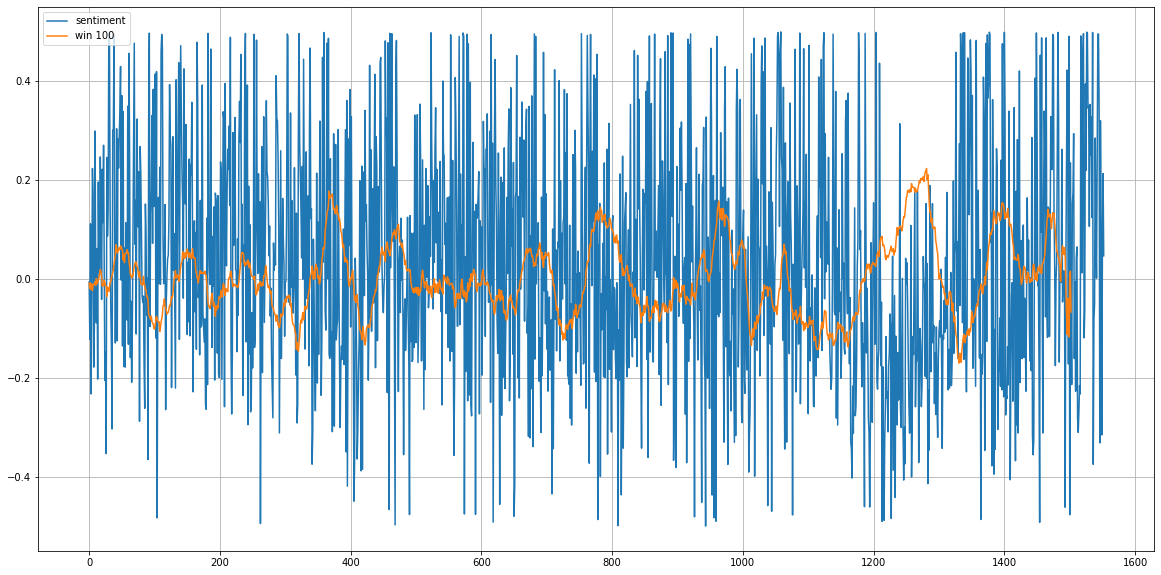

In [110]:
plt.figure(figsize=[20,10])
plt.grid(True)
plt.plot(sentiments, label='sentiment')
plt.plot(rolls, label='win 100')
plt.legend(loc=2)
plt.show()

In [85]:
np.argmax(rolls)

1503

In [82]:
cpd_df.iloc[1503]

sentiment     -0.212771
EMA_100        0.051680
EMA_50         0.061288
EMA_10        -0.000057
EMA_200        0.028223
ema10          0.056692
EMA_10_T+10   -0.040633
minus         -0.040576
Name: 2019-12-16 00:00:00, dtype: float64

In [90]:
# ema
cpd_df['EMA_100']= cpd_df['sentiment'].ewm(span=100, adjust=False).mean()
cpd_df['EMA_50']= cpd_df['sentiment'].ewm(span=50, adjust=False).mean()
cpd_df['EMA_10']= cpd_df['sentiment'].ewm(span=10, adjust=False).mean()
cpd_df['EMA_200']= cpd_df['sentiment'].ewm(span=200, adjust=False).mean()

cpd_df['ema10'] = cpd_df['EMA_100'].rolling(window=10).mean()

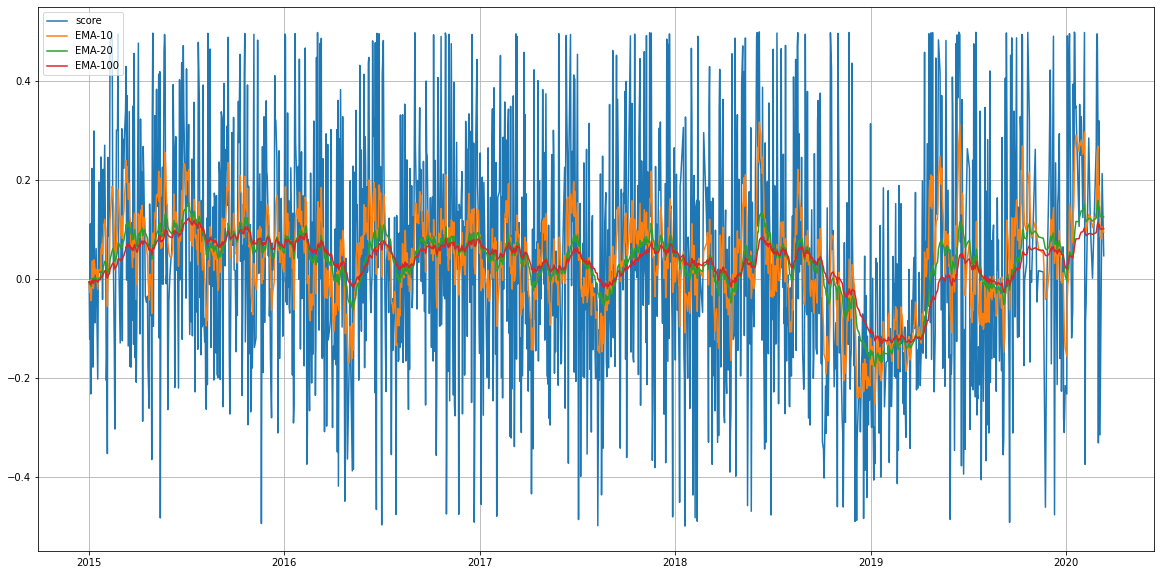

In [92]:
plt.figure(figsize=[20,10])
plt.grid(True)
plt.plot(cpd_df['sentiment'], label='score')
plt.plot(cpd_df['EMA_10'], label='EMA-10')
plt.plot(cpd_df['EMA_50'], label='EMA-20')

plt.plot(cpd_df['EMA_100'], label='EMA-100')

# plt.plot(cpd_df['ema10'], label='cpd')

plt.legend(loc=2)
plt.show()

In [48]:
# consider the ema, to compute the abrupt change point
max_score = cpd_df['EMA_100'].max()
min_score = cpd_df['EMA_100'].min()
max_score, min_score

(0.12421733216753336, -0.1292180184020231)

In [49]:
cpd_df['EMA_10_T+10'] = cpd_df['EMA_10'].shift(10)
cpd_df['minus'] = cpd_df['EMA_10_T+10']- cpd_df['EMA_10']

In [50]:
np.argmax(cpd_df['minus'])

1387

In [51]:
ARRAY= np.array(cpd_df['EMA_100'])

max_pos = np.argmax(ARRAY)
min_pos = np.argmin(ARRAY)
max_pos, min_pos

(148, 1261)

In [57]:
cpd_df.iloc[1261]

sentiment     -0.152188
EMA_100       -0.129218
EMA_50        -0.165729
EMA_10        -0.182301
EMA_200       -0.076554
ema10         -0.122706
EMA_10_T+10   -0.128681
minus          0.053620
Name: 2019-01-23 00:00:00, dtype: float64

In [35]:
import numpy as np
print('mean', np.mean(df['score']), ';',
     'standard:', np.std(df['score']), ';')

mean 73.0867559850648 ; standard: 26.66593114443994 ;


In [5]:
# navie methods.
# These are simple estimation techniques, such as the predicted value is 
# given the value equal to mean of preceding values of the time dependent variable, 
# or previous actual value. These are used for comparison with sophisticated modelling
# techniques.

# showing 1 st navive method

cpd_df['score_t-1']= cpd_df['score'].shift(1)

In [40]:
df_navive = cpd_df[['score_t-1', 'score']][1:]

In [41]:
from sklearn import metrics
from math import sqrt

true =df_navive['score']
prediction = df_navive['score_t-1']
error = sqrt(metrics.mean_squared_error(true, prediction))
print('RMSE for Navie Method 1: ', error)

RMSE for Navie Method 1:  0.316053342261914


In [9]:
# 2nd navive method
from sklearn import metrics
from math import sqrt

cpd_df['score_rm'] = cpd_df['score'].rolling(100).mean().shift(1)
df_naive= cpd_df[['score', 'score_rm']].dropna()

true = df_naive['score']
prediction = df_naive['score_rm']
error= sqrt(metrics.mean_squared_error(true, prediction))
error

0.23347371684410434

In [7]:
# autoregression
split = len(cpd_df)- int(0.2* len(cpd_df))
split

2296

In [8]:
train, test= cpd_df['score'][0:split], cpd_df['score'][split:]

In [1]:
from statsmodels.graphics.tsaplots import plot_acf

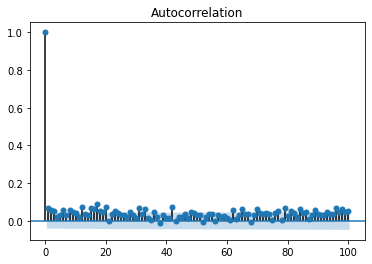

In [9]:
plot_acf(train, lags=100)
plt.show()

In [11]:
train

0       0.236362
1      -0.367095
2      -0.298088
3       0.171247
4       0.294896
          ...   
2291    0.156902
2292   -0.162794
2293   -0.374068
2294   -0.489428
2295   -0.158547
Name: score, Length: 2296, dtype: float64

In [12]:
# Exponential smoothing
# triple exponential smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train.values, trend='additive')
model_fit = model.fit()

In [13]:
predictions_ = model_fit.predict(len(test))

In [14]:
len(test)

573

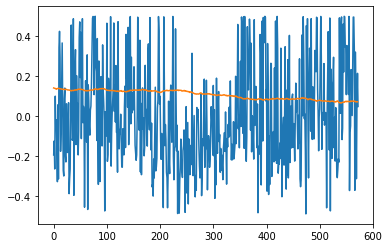

In [15]:
plt.plot(test.values)
plt.plot(predictions_[1:573])

In [16]:
cpd_df

,date,score
0,2006-06-13,0.236362
1,2006-11-23,-0.367095
2,2007-01-05,-0.298088
3,2007-01-07,0.171247
4,2007-01-11,0.294896
...,...,...
2864,2020-03-04,0.109948
2865,2020-03-05,-0.314568
2866,2020-03-08,0.066141
2867,2020-03-09,0.213687
